---
## Setup

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import auc

In [90]:
train = pd.read_csv('./../Data/training_dataset.csv')
test = pd.read_csv('./../Data/validation_set.csv')


---
## Data Exploration

In [91]:
train.head()

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,531036,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,...,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,999241,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,995002,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,932750,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,684699,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0


In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_number               22916 non-null  int64  
 1   usia                          22916 non-null  int64  
 2   pekerjaan                     22916 non-null  object 
 3   status_perkawinan             22916 non-null  object 
 4   pendidikan                    22916 non-null  object 
 5   gagal_bayar_sebelumnya        22916 non-null  object 
 6   pinjaman_rumah                22916 non-null  object 
 7   pinjaman_pribadi              22916 non-null  object 
 8   jenis_kontak                  22916 non-null  object 
 9   bulan_kontak_terakhir         22916 non-null  object 
 10  hari_kontak_terakhir          22916 non-null  object 
 11  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 12  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 13  j

In [93]:
def check_anomali(df):
    print('Shape Data')
    print(df.shape)
    print('-'*10)
    print()
    print('Missing Value : ')
    print(df.isna().mean()*100)
    print('-'*10)
    print()
    print('Data Duplicated : ')
    print(df.duplicated().sum())

In [94]:
check_anomali(train)

Shape Data
(22916, 22)
----------

Missing Value : 
customer_number                 0.0
usia                            0.0
pekerjaan                       0.0
status_perkawinan               0.0
pendidikan                      0.0
gagal_bayar_sebelumnya          0.0
pinjaman_rumah                  0.0
pinjaman_pribadi                0.0
jenis_kontak                    0.0
bulan_kontak_terakhir           0.0
hari_kontak_terakhir            0.0
jumlah_kontak_kampanye_ini      0.0
hari_sejak_kontak_sebelumnya    0.0
jumlah_kontak_sebelumnya        0.0
hasil_kampanye_sebelumnya       0.0
tingkat_variasi_pekerjaan       0.0
indeks_harga_konsumen           0.0
indeks_kepercayaan_konsumen     0.0
suku_bunga_euribor_3bln         0.0
jumlah_pekerja                  0.0
pulau                           0.0
berlangganan_deposito           0.0
dtype: float64
----------

Data Duplicated : 
0


In [95]:
check_anomali(test)

Shape Data
(5729, 21)
----------

Missing Value : 
customer_number                 0.0
usia                            0.0
pekerjaan                       0.0
status_perkawinan               0.0
pendidikan                      0.0
gagal_bayar_sebelumnya          0.0
pinjaman_rumah                  0.0
pinjaman_pribadi                0.0
jenis_kontak                    0.0
bulan_kontak_terakhir           0.0
hari_kontak_terakhir            0.0
jumlah_kontak_kampanye_ini      0.0
hari_sejak_kontak_sebelumnya    0.0
jumlah_kontak_sebelumnya        0.0
hasil_kampanye_sebelumnya       0.0
tingkat_variasi_pekerjaan       0.0
indeks_harga_konsumen           0.0
indeks_kepercayaan_konsumen     0.0
suku_bunga_euribor_3bln         0.0
jumlah_pekerja                  0.0
pulau                           0.0
dtype: float64
----------

Data Duplicated : 
0


In [96]:
train.describe()

,customer_number,usia,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,berlangganan_deposito
count,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000
mean,550930.993193,40.016233,2.561878,962.210377,0.170143,0.077915,93.576541,-40.485717,3.617890,5166.773124,0.114069
std,259909.889175,10.438059,2.794178,187.566774,0.490611,1.576176,0.580586,4.641091,1.737591,72.479698,0.317902
min,100108.000000,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,325755.000000,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,553139.000000,38.000000,2.000000,999.000000,0.000000,1.100000,93.876000,-41.800000,4.857000,5191.000000,0.000000
75%,777157.500000,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,999997.000000,98.000000,42.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


---
## EDA

In [97]:
for col in test.columns:
    if train[col].dtype == 'object':  # pastikan hanya untuk kolom kategorikal
        train[col] = train[col].replace('unknown', np.nan)
        test[col] = test[col].replace('unknown', np.nan)

In [98]:
cat_cols_train = train.select_dtypes(include=['object', 'category'])
num_cols_train = train.select_dtypes(include='number')

cat_cols_test = test.select_dtypes(include=['object', 'category'])
num_cols_test = test.select_dtypes(include='number')

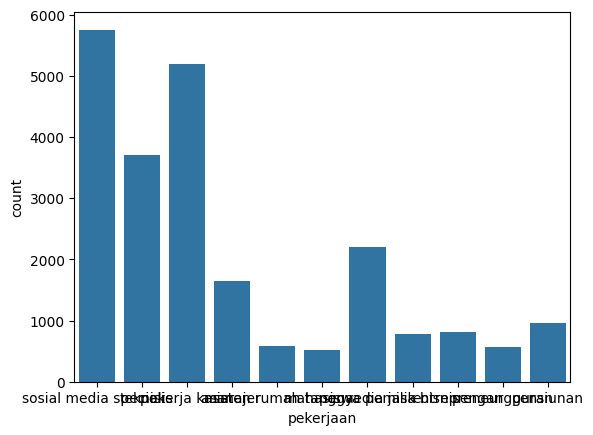

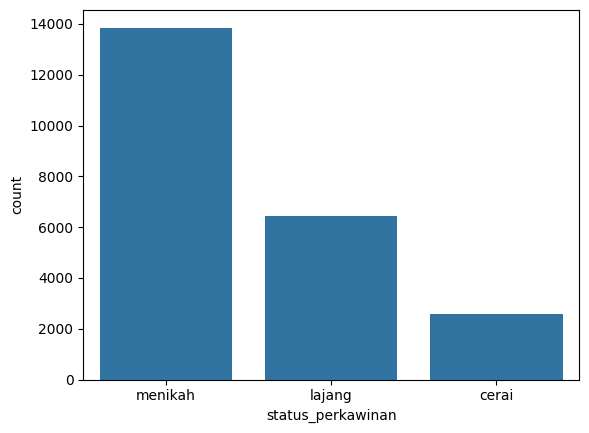

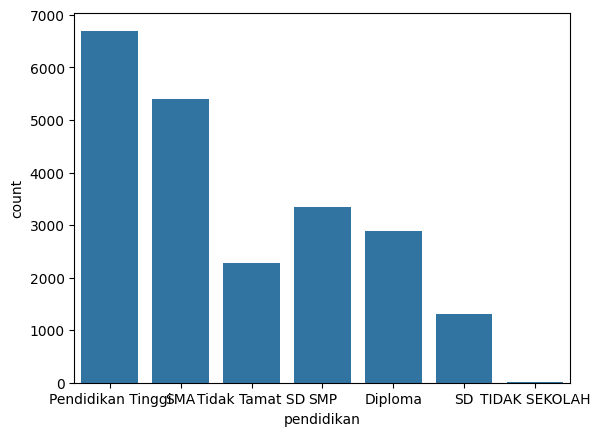

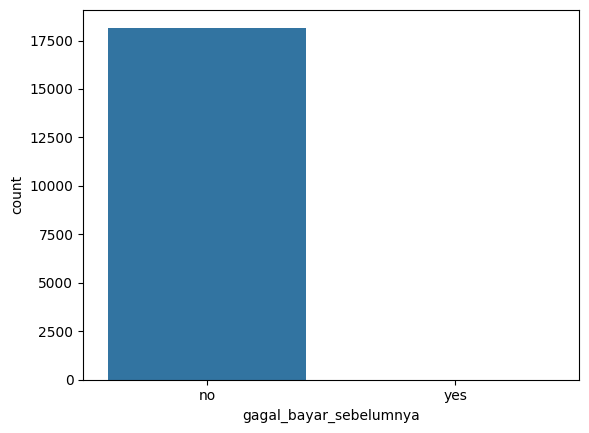

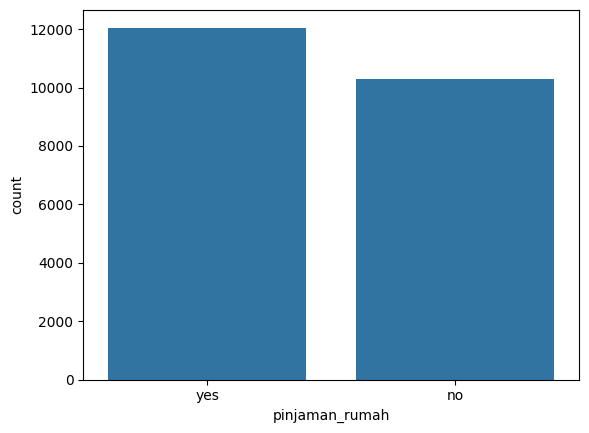

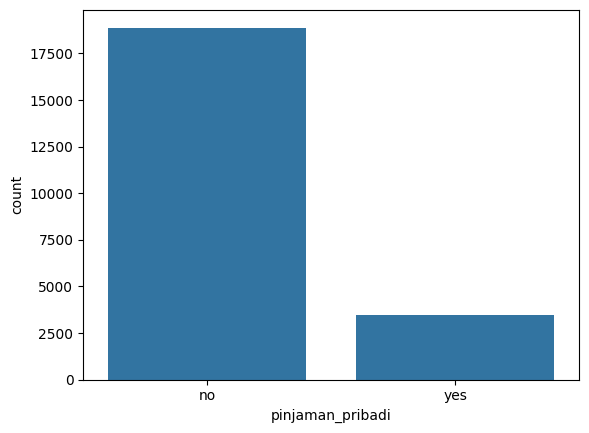

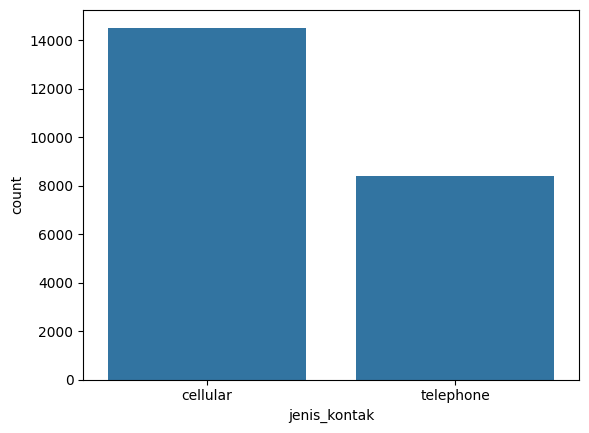

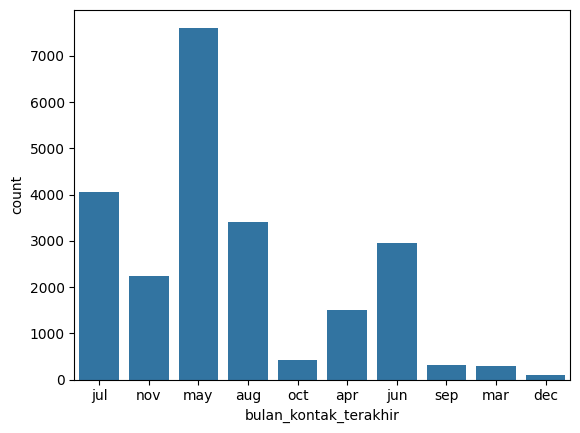

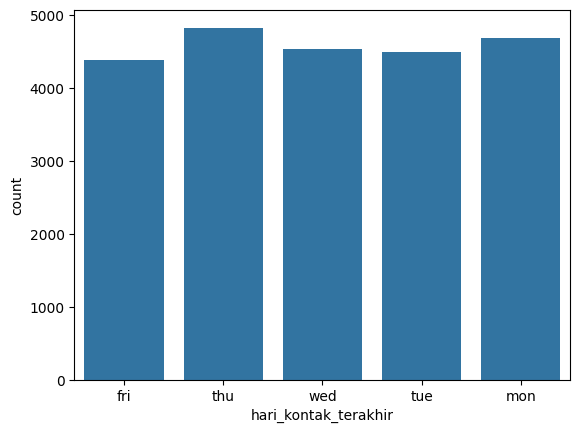

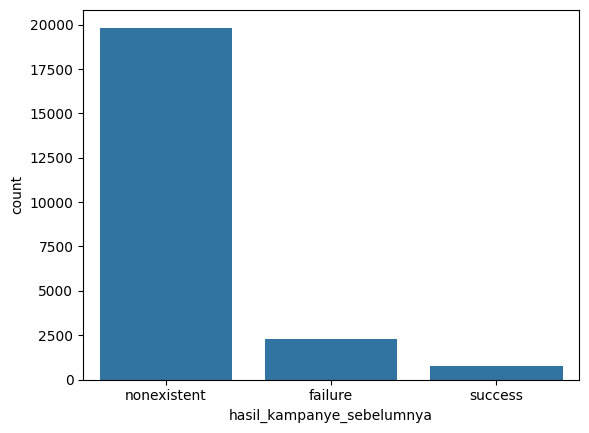

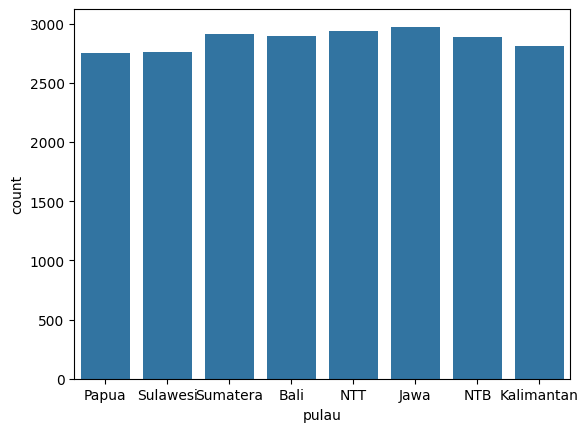

In [99]:
#visualization of categorical data
for col in cat_cols_train:
    sns.countplot(x=col, data=train)
    plt.show()

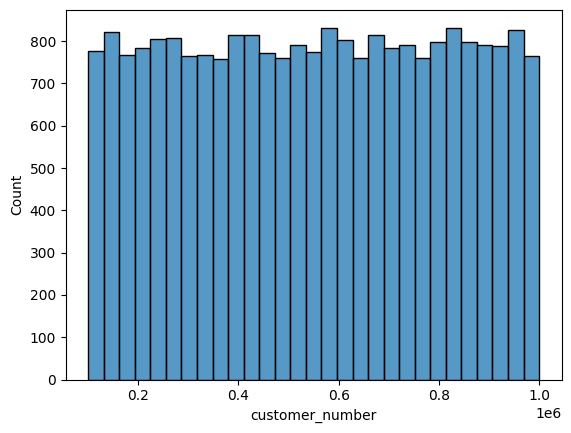

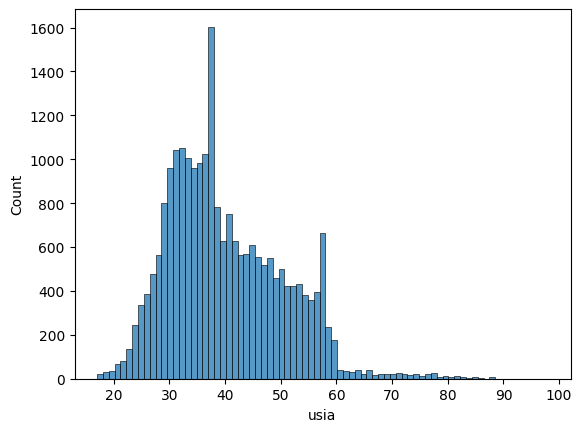

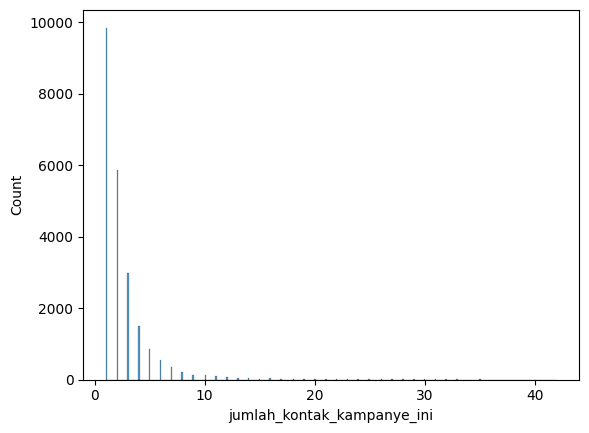

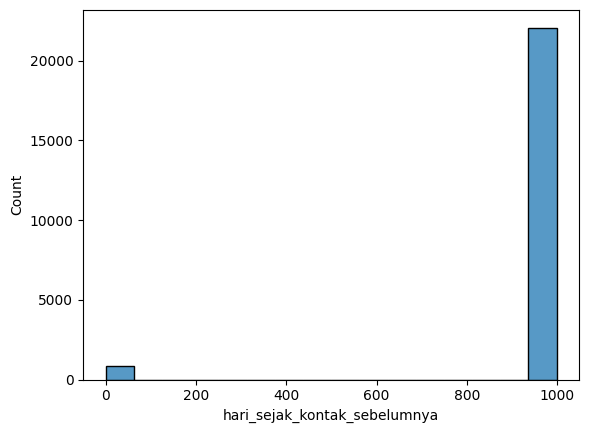

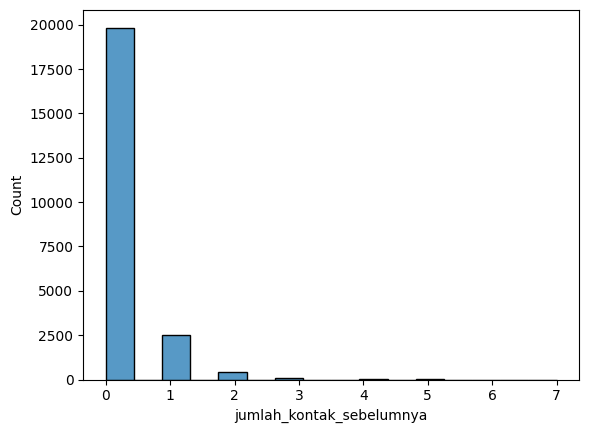

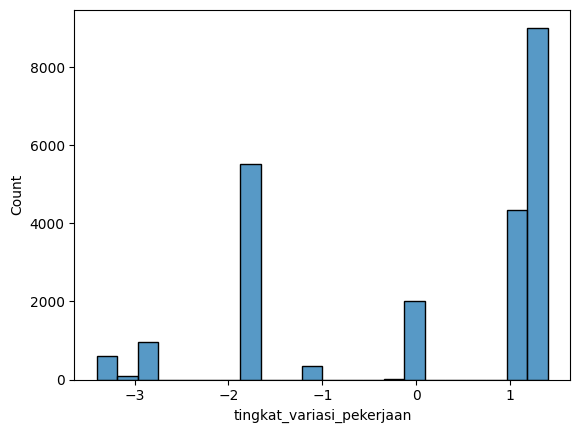

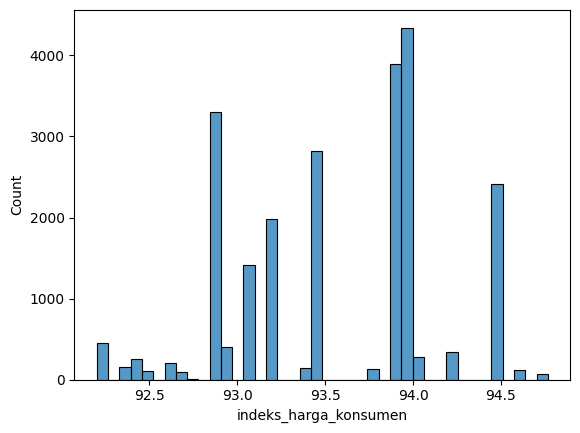

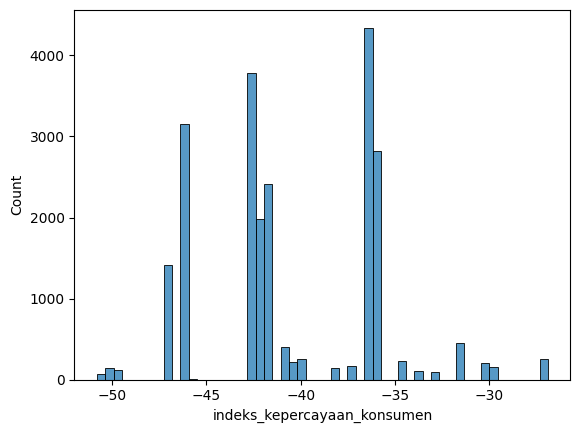

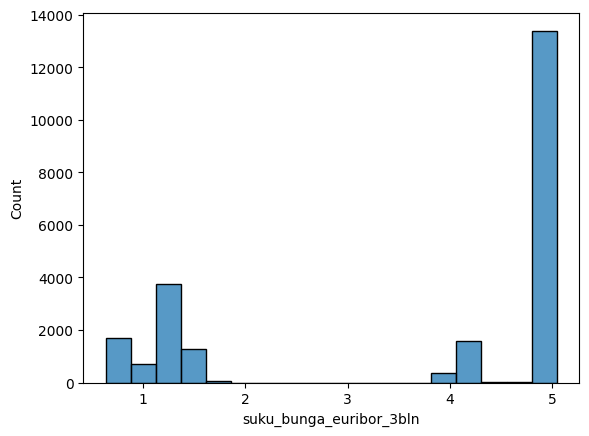

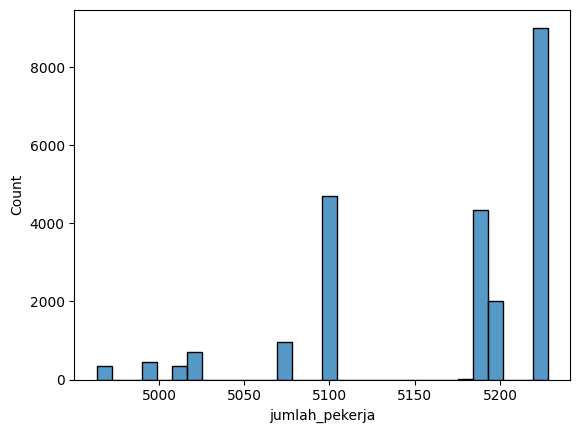

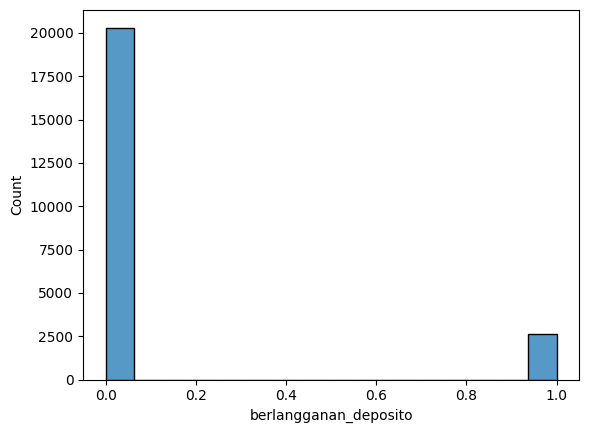

In [100]:
#visualization of numerical data
for col in num_cols_train:
    sns.histplot(x=col, data=train)
    plt.show()

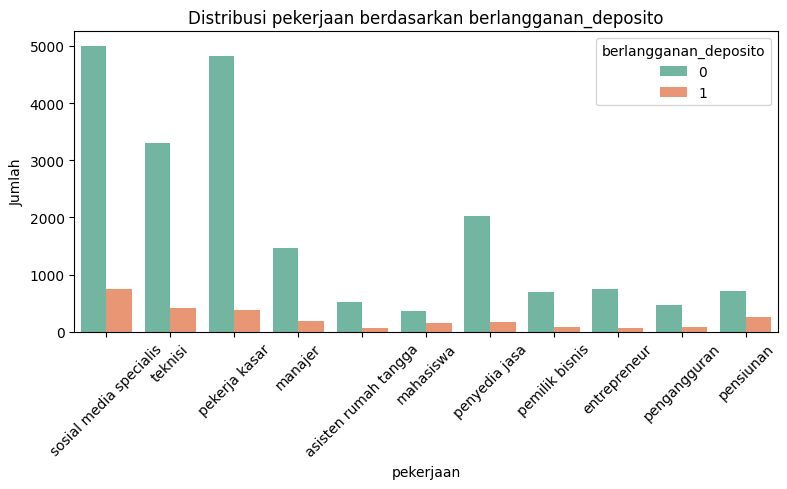

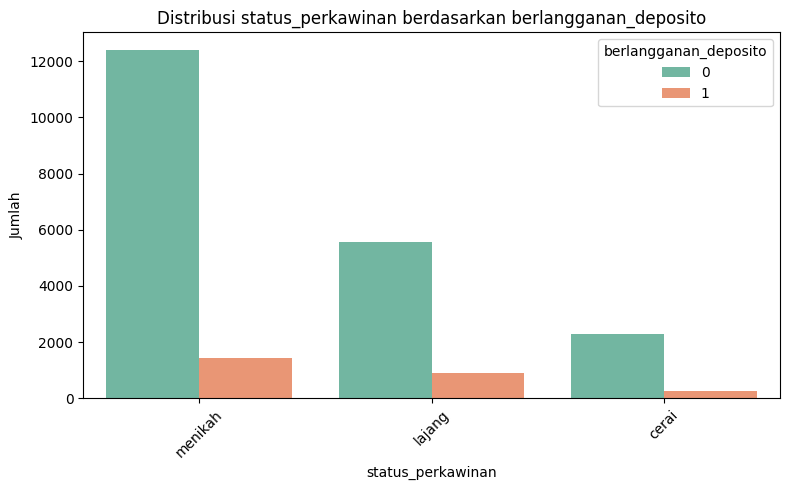

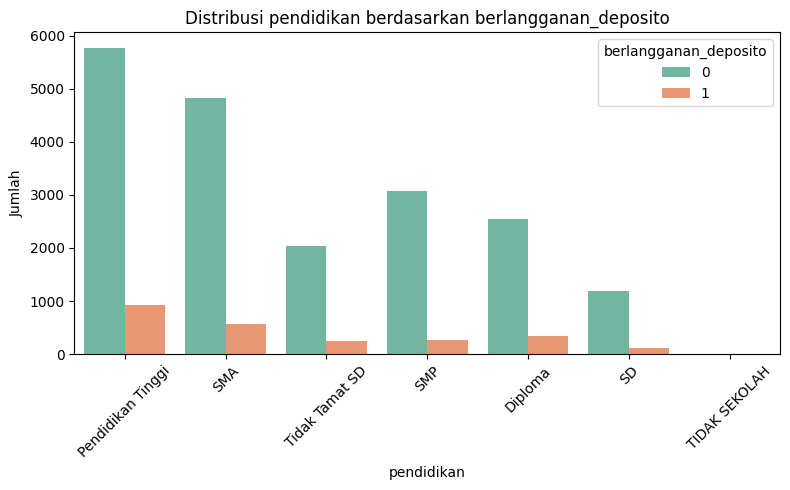

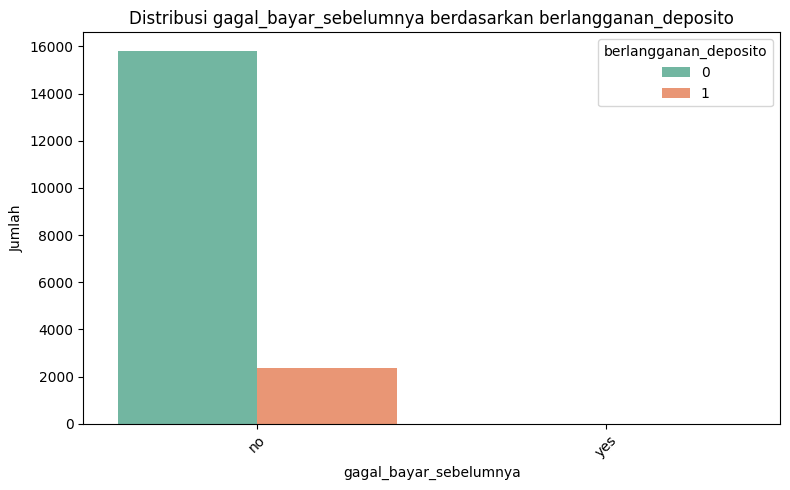

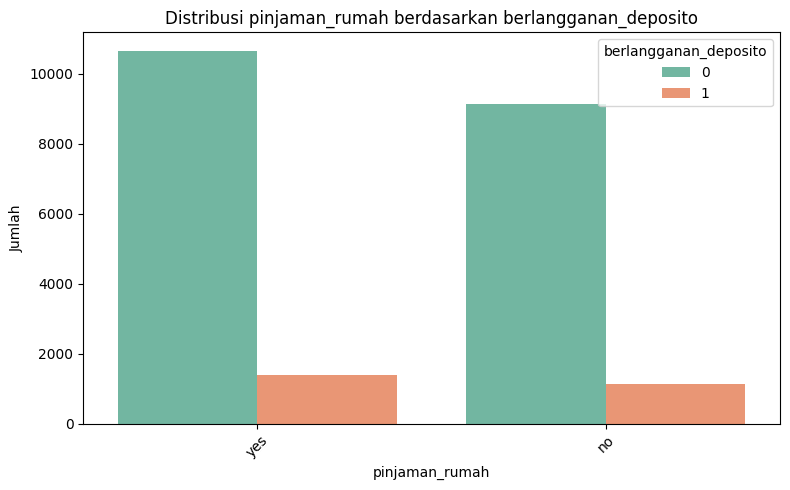

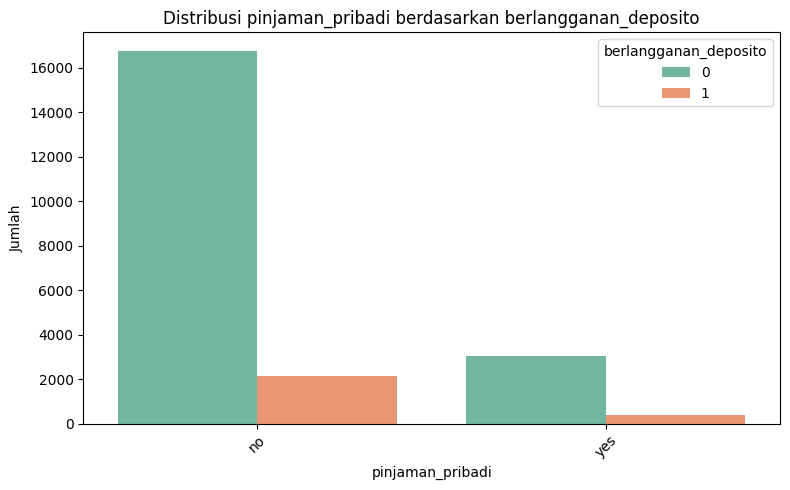

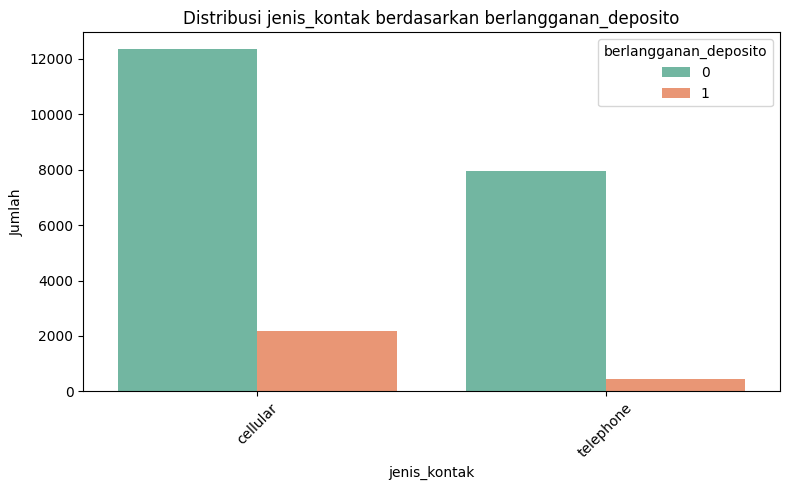

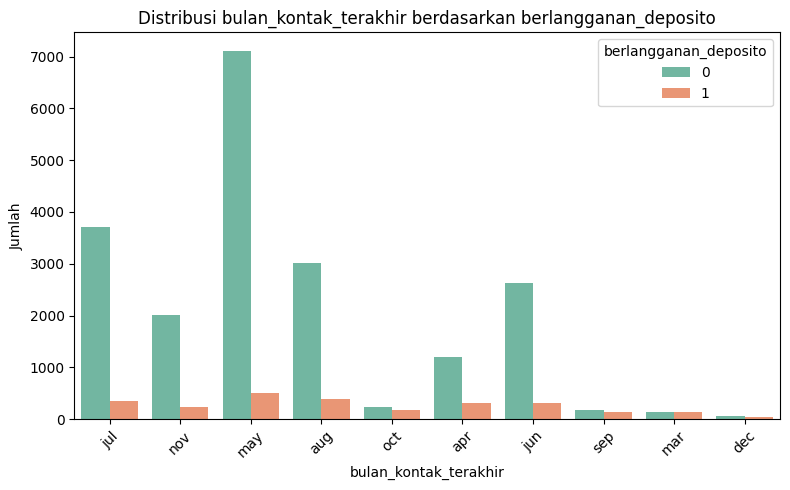

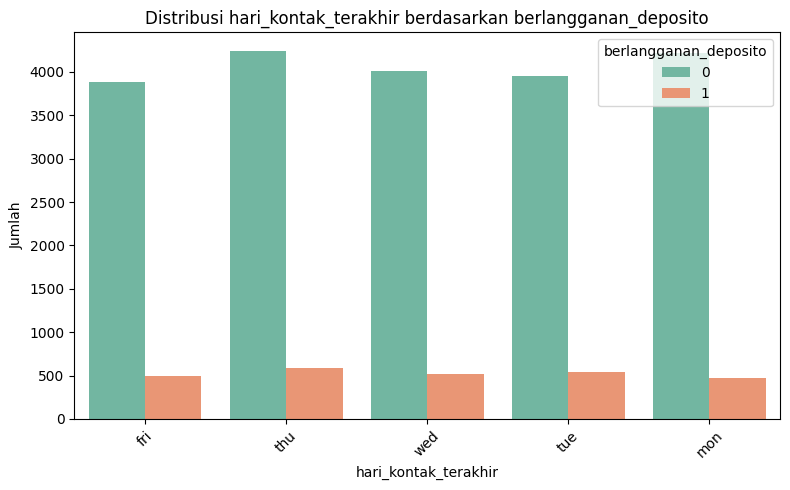

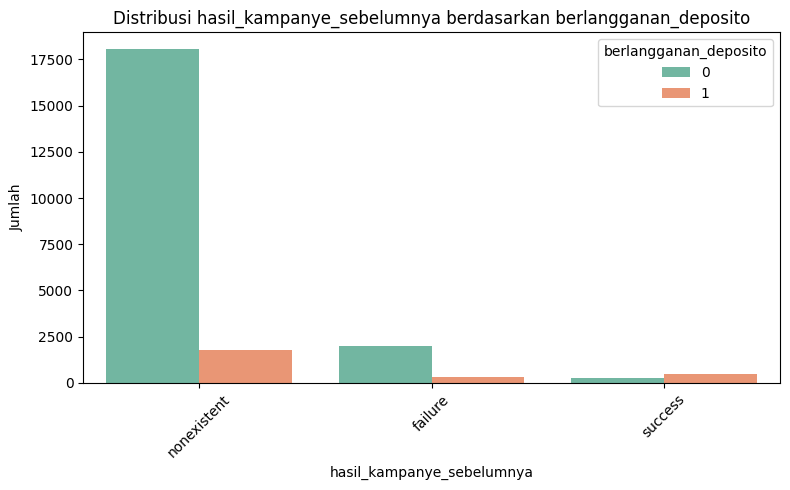

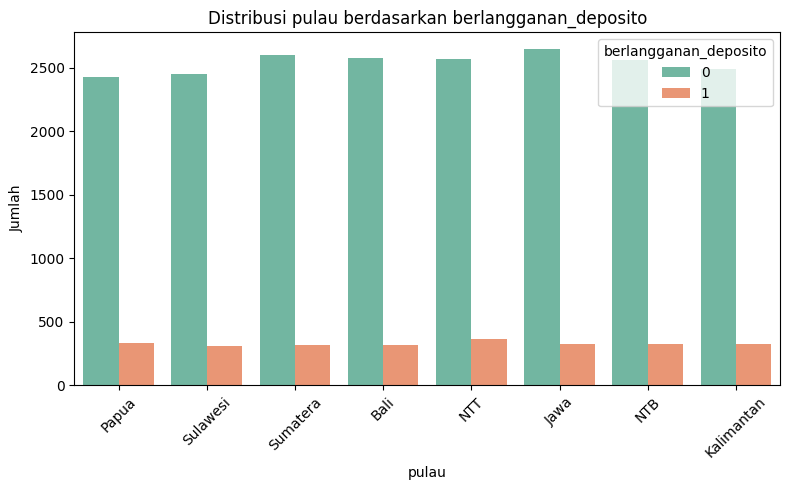

In [101]:
def plot_categorical_distribution(df, categorical_cols, target_col):
    for col in categorical_cols:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x=col, hue=target_col, palette='Set2')
        plt.title(f'Distribusi {col} berdasarkan {target_col}')
        plt.xlabel(col)
        plt.ylabel('Jumlah')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Contoh pemanggilan (pastikan target_col adalah string, bukan Series)
plot_categorical_distribution(train, cat_cols_train, 'berlangganan_deposito')


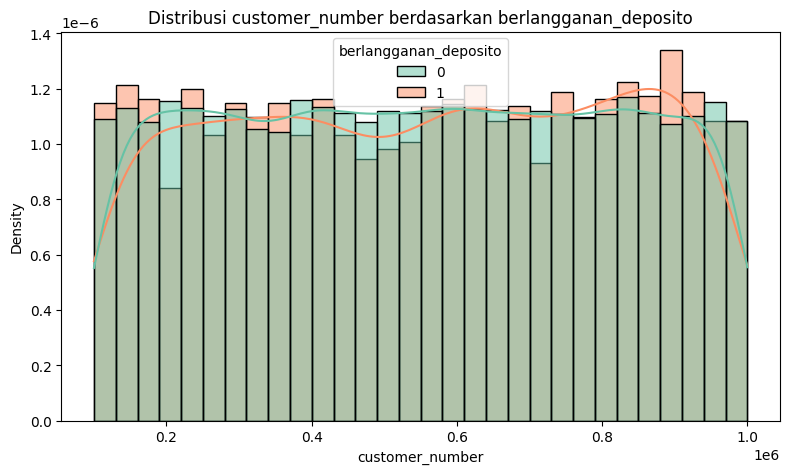

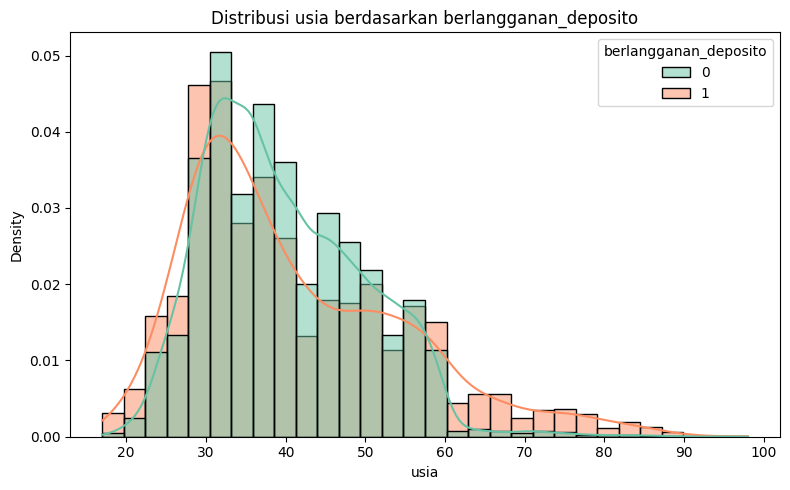

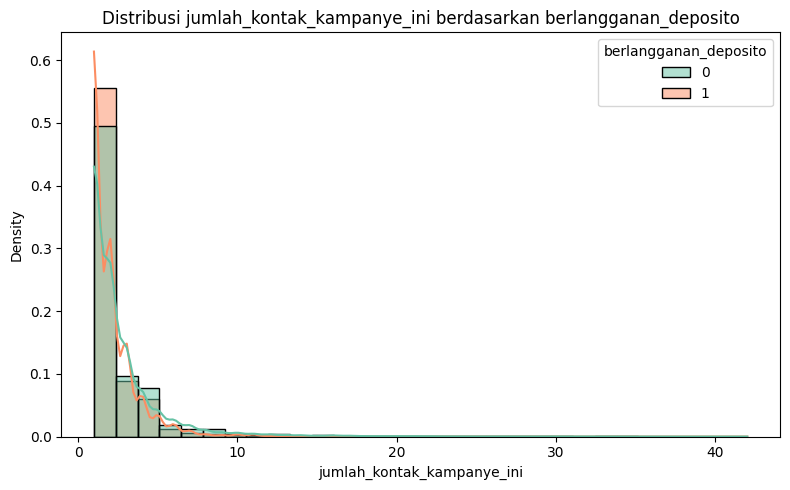

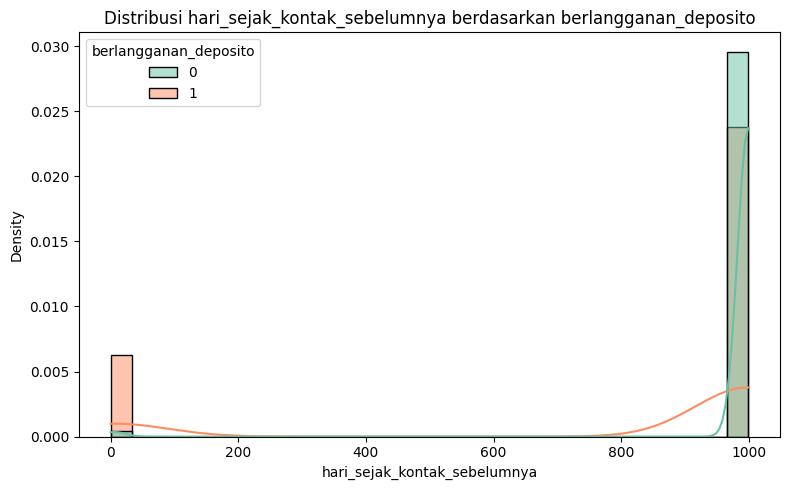

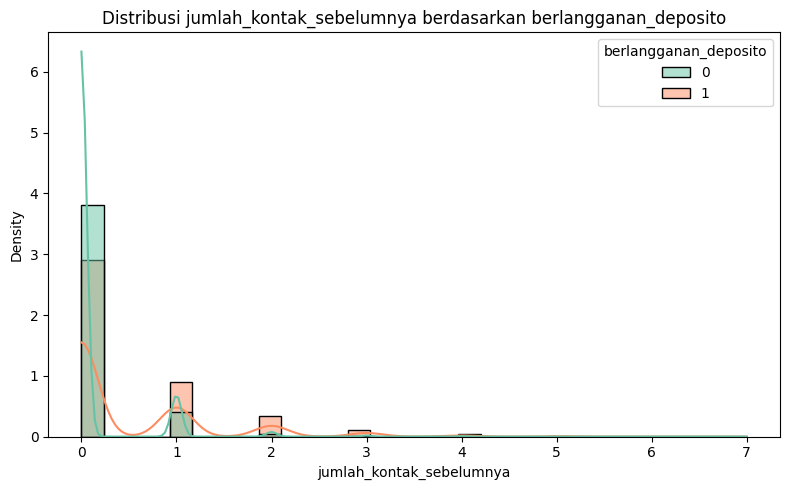

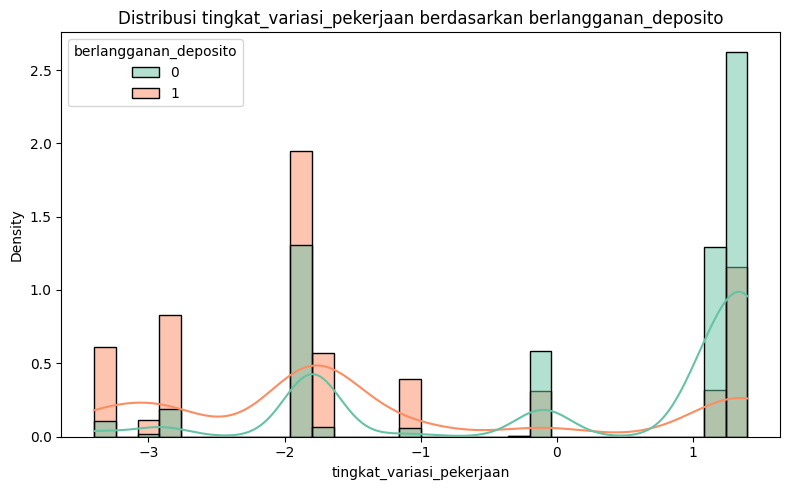

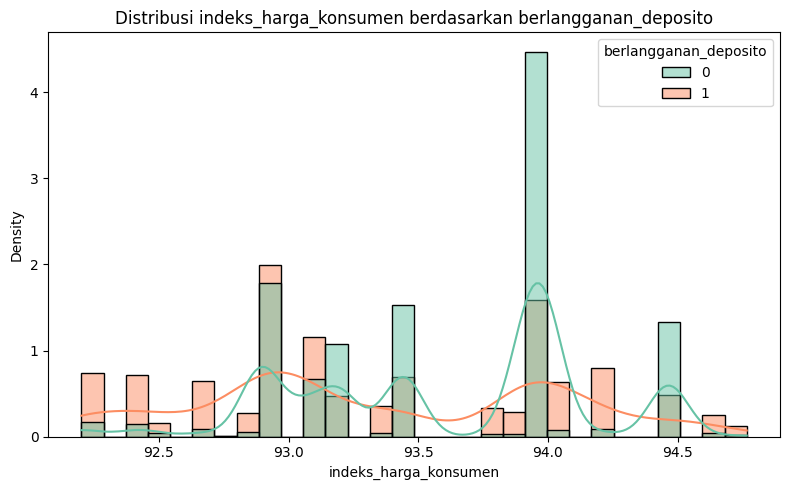

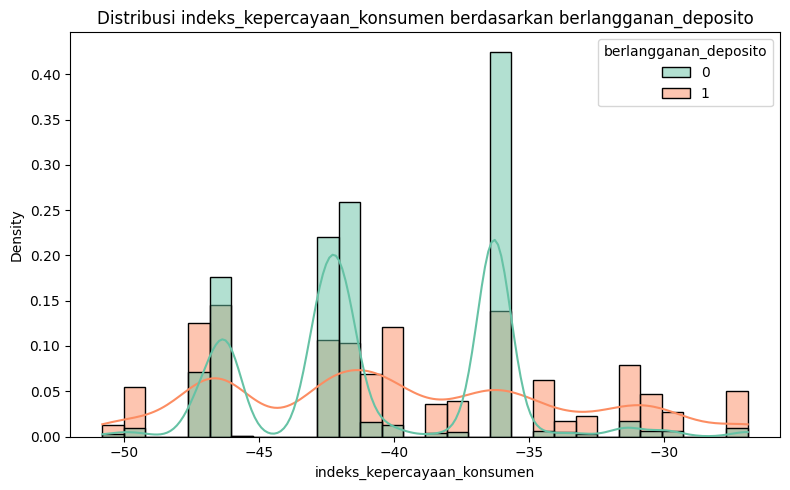

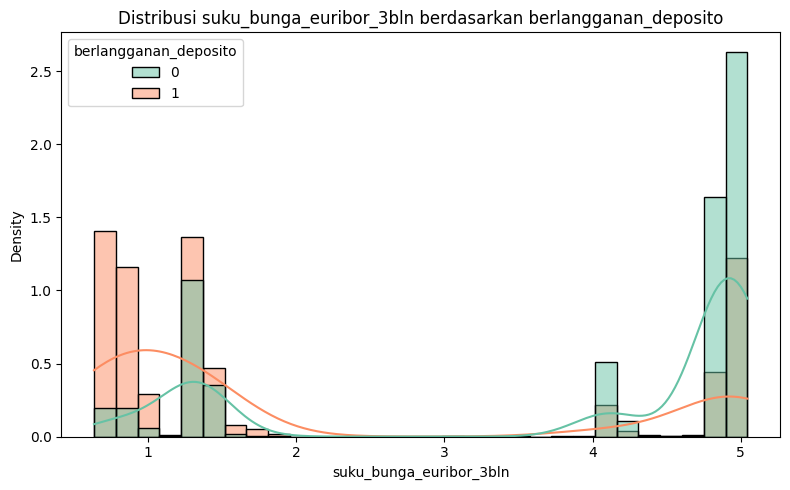

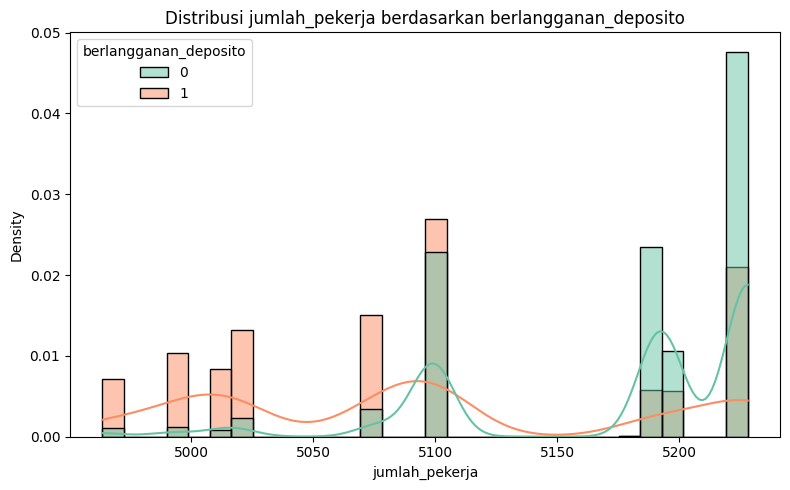

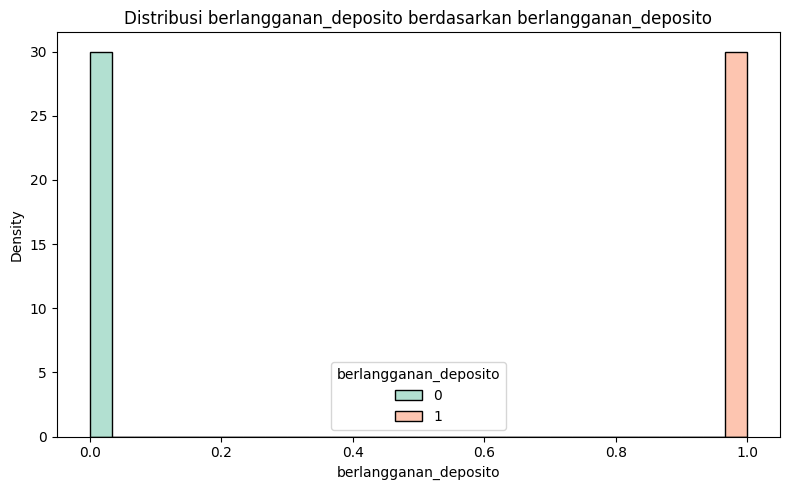

In [102]:
def plot_histplots(df, num_cols, target_col, bins=30):
    for col in num_cols:
        plt.figure(figsize=(8, 5))
        sns.histplot(data=df, x=col, hue=target_col, bins=bins, kde=True, stat="density", common_norm=False, palette='Set2')
        plt.title(f'Distribusi {col} berdasarkan {target_col}')
        plt.tight_layout()
        plt.show()


plot_histplots(train, num_cols_train, 'berlangganan_deposito')

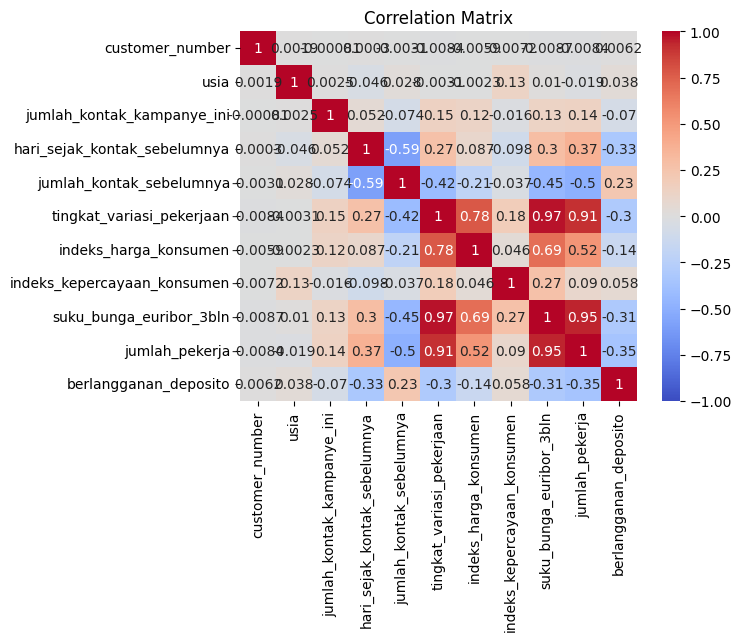

In [103]:
#heatmap correlation numerical
corr_matrix = train[num_cols_train.columns.tolist()].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(train[num_cols_train.columns.tolist()])

# Hitung VIF untuk setiap fitur
vif_data = pd.DataFrame()
vif_data["Fitur"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                           Fitur            VIF
0                          const  529739.614517
1                customer_number       1.000245
2                           usia       1.020656
3     jumlah_kontak_kampanye_ini       1.031095
4   hari_sejak_kontak_sebelumnya       1.687910
5       jumlah_kontak_sebelumnya       1.799355
6      tingkat_variasi_pekerjaan      33.493595
7          indeks_harga_konsumen       6.444646
8    indeks_kepercayaan_konsumen       2.660561
9        suku_bunga_euribor_3bln      64.977754
10                jumlah_pekerja      31.645374
11         berlangganan_deposito       1.216804


In [105]:
# Fitur quasi-constant: mayoritas nilainya sama (default threshold = 0.99)
threshold = 0.96
quasi_constant_features = []

for col in train.columns:
    top_freq = train[col].value_counts(normalize=True).values[0]
    if top_freq >= threshold:
        quasi_constant_features.append(col)

print(f"Quasi-constant features ({len(quasi_constant_features)}):")
print(quasi_constant_features)

Quasi-constant features (2):
['gagal_bayar_sebelumnya', 'hari_sejak_kontak_sebelumnya']


In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_number               22916 non-null  int64  
 1   usia                          22916 non-null  int64  
 2   pekerjaan                     22723 non-null  object 
 3   status_perkawinan             22869 non-null  object 
 4   pendidikan                    21924 non-null  object 
 5   gagal_bayar_sebelumnya        18171 non-null  object 
 6   pinjaman_rumah                22337 non-null  object 
 7   pinjaman_pribadi              22337 non-null  object 
 8   jenis_kontak                  22916 non-null  object 
 9   bulan_kontak_terakhir         22916 non-null  object 
 10  hari_kontak_terakhir          22916 non-null  object 
 11  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 12  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 13  j

In [107]:
train.drop(['tingkat_variasi_pekerjaan','suku_bunga_euribor_3bln','jumlah_pekerja',
            'gagal_bayar_sebelumnya', 'hari_sejak_kontak_sebelumnya','customer_number'], inplace=True, axis=1)

test.drop(['tingkat_variasi_pekerjaan','suku_bunga_euribor_3bln','jumlah_pekerja',
            'gagal_bayar_sebelumnya', 'hari_sejak_kontak_sebelumnya','customer_number'], inplace=True, axis=1)

---
## Engineering

In [108]:
train['usia_group'] = pd.cut(train['usia'], bins=[0, 25, 45, 65, 100], labels=['muda', 'dewasa', 'paruh_baya', 'lansia'])
test['usia_group'] = pd.cut(test['usia'], bins=[0, 25, 45, 65, 100], labels=['muda', 'dewasa', 'paruh_baya', 'lansia'])

train['punya_kedua_pinjaman'] = (
    (train['pinjaman_rumah'] == 'yes') & (train['pinjaman_pribadi'] == 'yes')
).astype(int)

train['punya_pinjaman_tunggal'] = (
    ((train['pinjaman_rumah'] == 'yes') ^ (train['pinjaman_pribadi'] == 'yes'))
).astype(int)

test['punya_kedua_pinjaman'] = (
    (test['pinjaman_rumah'] == 'yes') & (test['pinjaman_pribadi'] == 'yes')
).astype(int)

test['punya_pinjaman_tunggal'] = (
    ((test['pinjaman_rumah'] == 'yes') ^ (test['pinjaman_pribadi'] == 'yes'))
).astype(int)

train['pendidikan'] = train['pendidikan'].replace({
    'tidak tamat SD': 'tidak sekolah',
    'ttidak sekolah': 'tidak sekolah'  # typo dari 'tidak sekolah' mungkin?
})
test['pendidikan'] = test['pendidikan'].replace({
    'tidak tamat SD': 'tidak sekolah',
    'ttidak sekolah': 'tidak sekolah'  # typo dari 'tidak sekolah' mungkin?
})

---
## Model

In [109]:
train.select_dtypes(exclude=np.number).columns

Index(['pekerjaan', 'status_perkawinan', 'pendidikan', 'pinjaman_rumah',
       'pinjaman_pribadi', 'jenis_kontak', 'bulan_kontak_terakhir',
       'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya', 'pulau',
       'usia_group'],
      dtype='object')

#### Pake Random Search

In [110]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from category_encoders import TargetEncoder

In [111]:
cat_features = ['pekerjaan', 'status_perkawinan', 'pendidikan', 'pinjaman_rumah',
       'pinjaman_pribadi', 'jenis_kontak', 'bulan_kontak_terakhir',
       'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya', 'pulau',
       'usia_group']

X = train.drop('berlangganan_deposito', axis=1)
y = train['berlangganan_deposito']


In [112]:
target_encoder = TargetEncoder(cols=cat_features)

# Fit dan transform data
X_encoded = target_encoder.fit_transform(X[cat_features], y)

# Gabungkan kembali dengan fitur lain (jika ada)
X_final = X.drop(columns=cat_features).join(X_encoded)
X_final = X_final.fillna(X_final.median(numeric_only=True))


In [113]:
import optuna
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from collections import Counter

counter = Counter(y)

# Fungsi untuk tuning Optuna
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': counter[0] / counter[1],
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'random_state': 42,
        'verbosity': 0
    }

    y_pred = np.zeros(len(X_final))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in cv.split(X_final, y):
        X_train, X_val = X_final.iloc[train_idx], X_final.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBClassifier(**param)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        y_pred[val_idx] = model.predict_proba(X_val)[:, 1]

    return roc_auc_score(y, y_pred)

# Buat dan jalankan studi
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)

print("[XGBOOST] Best params:", study_xgb.best_params)
print("[XGBOOST] Best AUC:", study_xgb.best_value)


[I 2025-06-02 23:15:00,870] A new study created in memory with name: no-name-79edb52e-2962-4ae1-aca6-39ab39c3d1bd


[I 2025-06-02 23:15:34,323] Trial 0 finished with value: 0.7316649992911173 and parameters: {'n_estimators': 684, 'learning_rate': 0.2454245586612716, 'max_depth': 4, 'reg_lambda': 2.179971056134986, 'reg_alpha': 0.011822758144783955, 'subsample': 0.6248201483653157, 'colsample_bytree': 0.8565658327772457}. Best is trial 0 with value: 0.7316649992911173.
[I 2025-06-02 23:16:06,178] Trial 1 finished with value: 0.7505290522445427 and parameters: {'n_estimators': 849, 'learning_rate': 0.02674139809415691, 'max_depth': 9, 'reg_lambda': 1.6903735334404524, 'reg_alpha': 0.10301534434148026, 'subsample': 0.8129936562478848, 'colsample_bytree': 0.8504933615068311}. Best is trial 1 with value: 0.7505290522445427.
[I 2025-06-02 23:16:11,627] Trial 2 finished with value: 0.7495489399282766 and parameters: {'n_estimators': 271, 'learning_rate': 0.1459074303922624, 'max_depth': 5, 'reg_lambda': 0.1191467756380222, 'reg_alpha': 0.2060206537688372, 'subsample': 0.6118306253984385, 'colsample_bytree'

[XGBOOST] Best params: {'n_estimators': 213, 'learning_rate': 0.012438434794471176, 'max_depth': 8, 'reg_lambda': 8.297428097394018, 'reg_alpha': 9.234163225003297, 'subsample': 0.5091744974060293, 'colsample_bytree': 0.661548378160058}
[XGBOOST] Best AUC: 0.79078008905617


In [114]:
a

NameError: name 'a' is not defined

In [ ]:
test['berlangganan_deposito'] = final.predict_proba(test)[:, 1]


<Axes: ylabel='Frequency'>

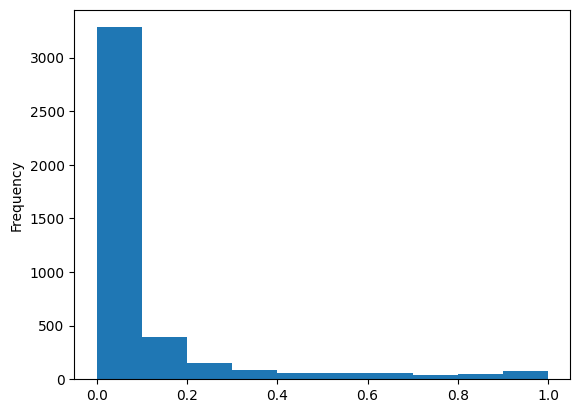

In [ ]:
test['berlangganan_deposito'].plot(kind='hist')

In [ ]:
test['berlangganan_deposito_rounded'] = test['berlangganan_deposito'].apply(lambda x: round(x))
test['berlangganan_deposito_rounded'].value_counts()

berlangganan_deposito_rounded
0    3974
1     279
Name: count, dtype: int64